# Example - Loading and transforming data

In this example we have a lightsheet dataset in OME-Zarr format, along with an atlas (ABAv3) in NIFTI. We have processed the dataset in SPIMquant to obtain NIFTI warps between these, and in this example we show how we can use the warps to transform microscopy data.

In [1]:
from dask.distributed import Client
client = Client(processes=False)  # start distributed scheduler locally
client # this provides link to the Dask dashboard

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://172.31.118.68:8787/status,
Dashboard: http://172.31.118.68:8787/status,Workers: 1
Total threads: 12,Total memory: 47.05 GiB
Status: running,Using processes: False
Comm: inproc://172.31.118.68/150315/1,Workers: 1
Dashboard: http://172.31.118.68:8787/status,Total threads: 12
Started: Just now,Total memory: 47.05 GiB
Comm: inproc://172.31.118.68/150315/4,Total threads: 12
Dashboard: http://172.31.118.68:43079/status,Memory: 47.05 GiB
Nanny: None,


## ZarrNii class

The `ZarrNii` class represents both OME-Zarr and NIFTI data, and we can load existing datasets using `.from_path()`. Note we can use the same function for both OME-Zarr and NIFTI datasets.

In [2]:
from zarrnii import ZarrNii

znimg = ZarrNii.from_path('/cifs/prado/Kate/AK_Pipeline_LSM/spimprep/bids/sub-o28/micr/sub-o28_sample-brain_acq-prestitched_SPIM.ome.zarr',level=0)
znseg = ZarrNii.from_path('/local/SPIMquant_oznbranch/spimquant/results/tpl-ABAv3/tpl-ABAv3_desc-LR_dseg.nii.gz')
                             

{'scale': [1, 0.004, 0.0018, 0.0018], 'type': 'scale'}
{'scale': [1, 0.004, 0.0018, 0.0018], 'type': 'scale'}


### Taking a look under the hood of a ZarrNii instance

Inspecting the instances, we see that each one contains `vox2ras` and `ras2vox` transformations, as `Transform` objects, along with a `dask.array`, `darr`, which contains the chunked data.


In [3]:
znimg

ZarrNii(darr=dask.array<getitem, shape=(1, 2212, 11732, 7439), dtype=uint16, chunksize=(1, 1, 4096, 4096), chunktype=numpy.ndarray>, ras2vox=Transform(tfm_type=<TransformType.AFFINE_RAS: 1>, affine=array([[  -0.        ,   -0.        , -250.        ,   -0.        ],
       [  -0.        , -555.55555556,   -0.        ,   -0.        ],
       [-555.55555556,   -0.        ,   -0.        ,   -0.        ],
       [   0.        ,    0.        ,    0.        ,    1.        ]]), disp_xyz=None, disp_grid=None, disp_ras2vox=None), vox2ras=Transform(tfm_type=<TransformType.AFFINE_RAS: 1>, affine=array([[ 0.    ,  0.    , -0.0018,  0.    ],
       [ 0.    , -0.0018,  0.    ,  0.    ],
       [-0.004 ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  1.    ]]), disp_xyz=None, disp_grid=None, disp_ras2vox=None), axes_nifti=False)

In [4]:
znseg

ZarrNii(darr=dask.array<array, shape=(1, 456, 528, 320), dtype=float64, chunksize=(1, 255, 255, 255), chunktype=numpy.ndarray>, ras2vox=Transform(tfm_type=<TransformType.AFFINE_RAS: 1>, affine=array([[ 39.9999994 ,   0.        ,   0.        , 227.99998897],
       [  0.        ,  39.9999994 ,   0.        , 312.99998771],
       [  0.        ,   0.        ,  39.9999994 , 113.00000022],
       [  0.        ,   0.        ,   0.        ,   1.        ]]), disp_xyz=None, disp_grid=None, disp_ras2vox=None), vox2ras=Transform(tfm_type=<TransformType.AFFINE_RAS: 1>, affine=array([[ 0.025     ,  0.        ,  0.        , -5.69999981],
       [ 0.        ,  0.025     ,  0.        , -7.82499981],
       [ 0.        ,  0.        ,  0.025     , -2.82500005],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), disp_xyz=None, disp_grid=None, disp_ras2vox=None), axes_nifti=True)

The OME-Zarr datasets are ordered by CZYX axes, whereas the NIFTI are ordered by CXYZ. The axis ordering is indicated by the `axes_nifti` attribute. The `vox2ras` for a NIFTI dataset is simply the `affine` you would obtain from `nibabel`. For an OME-Zarr dataset, this `vox2ras` transformation also includes a reordering from ZYX to XYZ, so that the **RAS** space we use is identical for both.

#### Dask arrays

The Dask arrays are nicely visualized by Dask:

In [5]:
znimg.darr

dask.array<getitem, shape=(1, 2212, 11732, 7439), dtype=uint16, chunksize=(1, 1, 4096, 4096), chunktype=numpy.ndarray>

In [6]:
znseg.darr

dask.array<array, shape=(1, 456, 528, 320), dtype=float64, chunksize=(1, 255, 255, 255), chunktype=numpy.ndarray>

Note, you can alter the chunk size when using the `from_path` function:

In [7]:
znimg_chunk1k = ZarrNii.from_path('/cifs/prado/Kate/AK_Pipeline_LSM/spimprep/bids/sub-o28/micr/sub-o28_sample-brain_acq-prestitched_SPIM.ome.zarr',
                                  level=0, chunks=(1,1000,1000,1000), rechunk=True)
znimg_chunk1k.darr


{'scale': [1, 0.004, 0.0018, 0.0018], 'type': 'scale'}
{'scale': [1, 0.004, 0.0018, 0.0018], 'type': 'scale'}


dask.array<rechunk-merge, shape=(1, 2212, 11732, 7439), dtype=uint16, chunksize=(1, 1000, 1000, 1000), chunktype=numpy.ndarray>

## Extracting high-res microscopy subvolumes as NIFTI

In this example, we'll use our atlas segmentation to obtain a bounding box around a label (in this case the dentate gyrus).


In [8]:
#here is an example of cropping using a label, and writing that out as a nifti

#first we obtain the bounding box, knowing that the label 476 is the L Dentate Gyrus granule cell layer
# then use to_nifti() to write to a file.
padding=1
(bbox_min,bbox_max) = znseg.get_bounding_box_around_label(476,ras_coords=True,padding=padding)
(znseg.crop_with_bounding_box(bbox_min,bbox_max,ras_coords=True)
        .to_nifti(f'cropped_seg_pad-{padding}.nii'))


/local/scratch/pypoetry_venv/zarrnii-bN9WqXf7-py3.9/lib/python3.9/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 587.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/local/scratch/pypoetry_venv/zarrnii-bN9WqXf7-py3.9/lib/python3.9/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 253.01 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [9]:
# if we want e.g. to crop the same structure in the subject microscopy image, 
# we can either transform the image and use a cropped ref, or, we can transform the bounding box corners

In [10]:
# to do the latter, we can use:
znseg.apply_transform_flo_to_ref_indices(ref_dimg=znimg, 

SyntaxError: unexpected EOF while parsing (2325672928.py, line 2)

In [ ]:
#now crop the ref image:
cropped_seg = znseg.crop_with_bounding_box(bbox_min,bbox_max,ras_coords=True)
cropped_seg.darr

In [ ]:
ref_cropped = znseg.crop_with_bounding_box(min_extent, max_extent)

Note now in the output the size has changed, along with the transforms.  Again, we haven't done any computing yet since crop is also **lazy**. 

In [ ]:
ref_cropped

In [ ]:
ref_cropped.darr

In [ ]:
#now let's crop a slice from the middle

In [ ]:
ref_slice = ref_cropped.crop_with_bounding_box([0,0,80],[128,118,81])
ref_slice.darr

In [ ]:
from zarrnii import Transform

#let's reload the lightsheet data but from a downsampled level
flo_znimg = ZarrNii.from_path('/cifs/prado/Kate/AK_Pipeline_LSM/spimprep/bids/sub-o28/micr/sub-o28_sample-brain_acq-prestitched_SPIM.ome.zarr',
                                  level=4)
resampled = flo_znimg.apply_transform(
    Transform.affine_ras_from_txt('/local/SPIMquant_oznbranch/spimquant/results/sub-o28/warps/sub-o28_sample-brain_acq-prestitched_from-subject_to-ABAv3_type-ras_desc-affine_xfm.txt'),
    ref_dimg=ref_slice)

resampled.darr

In [ ]:
resampled.to_nifti('dg_downsampled.nii')

### Zoomed reference
If we want higher-res, we can use a reference with a zoomed in FOV. We don't want to actually resample the reference image, just the shape of it, so we make use of an alternative to `from_path()`, which is `from_path_as_ref()`, which uses an empty array instead of the actual data. 

In [ ]:
ref_zoomed = ZarrNii.from_path_as_ref('/local/SPIMquant_oznbranch/spimquant/results/tpl-ABAv3/tpl-ABAv3_desc-LR_dseg.nii.gz',
                                      zooms=(0.005,0.005,0.005))
            


## Example simply writing downsampled NIFTI from OME-Zarr

In [10]:
from zarrnii import ZarrNii

In [ ]:
#test out writing to nifti downsampled
znimg_ds5 = (ZarrNii.from_path('/cifs/prado/Kate/AK_Pipeline_LSM/spimprep/bids/sub-o28/micr/sub-o28_sample-brain_acq-prestitched_SPIM.ome.zarr',
                                 level=5,channels=[0])
                .downsample_by_local_mean(ds_z=2**3) #same downsample rate as X and Y
                .to_nifti('sub-o28_stain-PI_ds-5_SPIM.nii'))


In [ ]:
znimg_ds5 = (ZarrNii.from_path('/cifs/prado/Kate/AK_Pipeline_LSM/spimprep/bids/sub-o28/micr/sub-o28_sample-brain_acq-prestitched_SPIM.ome.zarr',
                                 level=5,channels=[0])
                .downsample_by_local_mean(ds_z=2**3)
                .crop_with_bounding_box((4,6,1),(30,50,25))) #same downsample rate as X and Y
znimg_ds5.vox2ras.affine


In [ ]:
znimg_ds5.to_ome_zarr('test_crop.ome.zarr')

## Example writing cropped region to OME-zarr

In [22]:
#have ABAv3 already registered to subject, but in a downsampled space
#we can use this to get a bounding box, and specify it to be in RAS coordinates 
#so it can be used on the full res OME-Zarr
subj_dseg='/local/SPIMquant_oznbranch/spimquant/results/sub-o28/micr/sub-o28_sample-brain_acq-prestitched_from-ABAv3_level-5_desc-deform_dseg.nii.gz'
(bbox_min, bbox_max) = (ZarrNii.from_path(subj_dseg)
                            .get_bounding_box_around_label(476,ras_coords=True))

#here, we crop with the bbox
znimg_crop_dg = (ZarrNii.from_path('/cifs/prado/Kate/AK_Pipeline_LSM/spimprep/bids/sub-o28/micr/sub-o28_sample-brain_acq-prestitched_SPIM.ome.zarr',
                                   level=0,channels=[0,1])
                        .crop_with_bounding_box(bbox_min,bbox_max,ras_coords=True))
znimg_crop_dg.darr
                

/local/scratch/pypoetry_venv/zarrnii-bN9WqXf7-py3.9/lib/python3.9/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 179.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


{'scale': [1, 0.004, 0.0018, 0.0018], 'type': 'scale'}
{'scale': [1, 0.004, 0.0018, 0.0018], 'type': 'scale'}


dask.array<getitem, shape=(2, 1040, 2112, 2112), dtype=uint16, chunksize=(1, 1, 1952, 1760), chunktype=numpy.ndarray>

**Note:** This runs very fast, because it is not actually doing the computation yet. Any operation you perform on Dask arrays is **lazy**, meaning that it does not compute until you explicitly tell it to, with `compute()`. At that point it then runs everything, parallelizing where possible.

In [37]:
# the image is still pretty big, so lets just grab a single slice and visualize it

dg_slice = (znimg_crop_dg
            .crop_with_bounding_box((500,0,0),(501,2112,2112)))

dg_slice_channels = dg_slice.darr.compute()

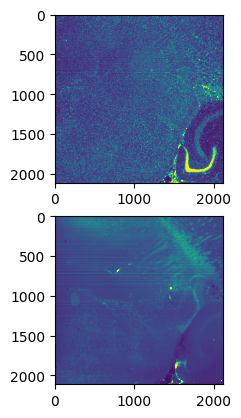

In [38]:
import matplotlib.pyplot as plt
plt.subplot(2,1,1)
plt.imshow(dg_slice_channels[0,:,:,:].squeeze(),clim=(0,1000))
plt.subplot(2,1,2)
plt.imshow(dg_slice_channels[1,:,:,:].squeeze(),clim=(0,1000))

In [ ]:
#we can also save the entire crop-volume to a new OME-Zarr file:
znimg_crop_dg.to_ome_zarr('dg_cropped.ome.zarr')

#Note: this automatically computes a multi-resolution pyramid when saving the data

affine_zarr
[[4.0000e-03 0.0000e+00 0.0000e+00 2.1760e+00]
 [0.0000e+00 1.8000e-03 0.0000e+00 7.0848e+00]
 [0.0000e+00 0.0000e+00 1.8000e-03 6.7392e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00]]
[0.004  0.0018 0.0018]
[-6.7392 -7.0848 -2.176 ]
